# 전국폐기물 발생 및 처리현황(2014년~2021년까지)
- 발생년도, 시도, 시군구, 폐기물 대분류, 폐기물 중분류, 폐기물 소분류, 전체발생량, 총계_재활용, 총계_소각, 총계_매립, 총계_기타
- 시군구별 페기물 종류별 발생량을 예측하는 모델을 만들어 봅니다

In [1]:
# 데이터 분석 패키지
import pandas as pd
import numpy as np

# 데이터 시각화 패키지
import matplotlib.pyplot as plt
import seaborn as sns

# 머신러닝 모델 및 평가 패키지
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve


In [2]:
# 데이터 불러오기
data = pd.read_csv('data/combined_data.csv')
data.head()

,발생년도,시도,시군구,폐기물 대분류,폐기물 중분류,폐기물 소분류,전체발생량,총계_재활용,총계_소각,총계_매립,총계_기타
0,2014,전국,합계,NaN,NaN,NaN,42355.2,24552.9,11530.6,6271.7,0.0
1,2014,서울,종로구,NaN,NaN,NaN,290.9,170.4,88.1,32.4,0.0
2,2014,서울,중구,NaN,NaN,NaN,410.6,258.6,132.6,19.4,0.0
3,2014,서울,용산구,NaN,NaN,NaN,245.4,158.1,79.1,8.2,0.0
4,2014,서울,성동구,NaN,NaN,NaN,228.6,142.6,65.1,20.9,0.0


In [3]:
# 데이터의 통계 정보 확인
data.describe()

,발생년도,전체발생량,총계_재활용,총계_소각,총계_매립,총계_기타
count,32403.000000,32403.000000,32403.000000,32403.000000,32403.000000,32403.000000
mean,2019.857421,54.758106,26.890739,18.494886,9.171287,0.199981
std,1.124376,811.147867,457.196534,279.030544,133.651107,3.902260
min,2014.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2019.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2020.000000,1.100000,0.000000,0.000000,0.000000,0.000000
75%,2021.000000,11.100000,2.400000,1.100000,0.450000,0.000000
max,2021.000000,47403.800000,27774.800000,13852.600000,6782.800000,295.600000


In [4]:
# 데이터의 결측치 확인
data.isnull().sum()

# 데이터의 타입 확인
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32403 entries, 0 to 32402
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   발생년도     32403 non-null  int64  
 1   시도       32403 non-null  object 
 2   시군구      32403 non-null  object 
 3   폐기물 대분류  31248 non-null  object 
 4   폐기물 중분류  31248 non-null  object 
 5   폐기물 소분류  31248 non-null  object 
 6   전체발생량    32403 non-null  float64
 7   총계_재활용   32403 non-null  float64
 8   총계_소각    32403 non-null  float64
 9   총계_매립    32403 non-null  float64
 10  총계_기타    32403 non-null  float64
dtypes: float64(5), int64(1), object(5)
memory usage: 2.7+ MB


In [5]:
# matplotlib 한글 폰트 오류 문제 해결, 맥,리눅스,윈도우 별로 폰트 설정
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Linux':
    # path = "/usr/share/fonts/NanumFont/NanumGothic.ttf"
    path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.rc('font', family=font_name)
else:
    print('알수없는 시스템. 미적용')



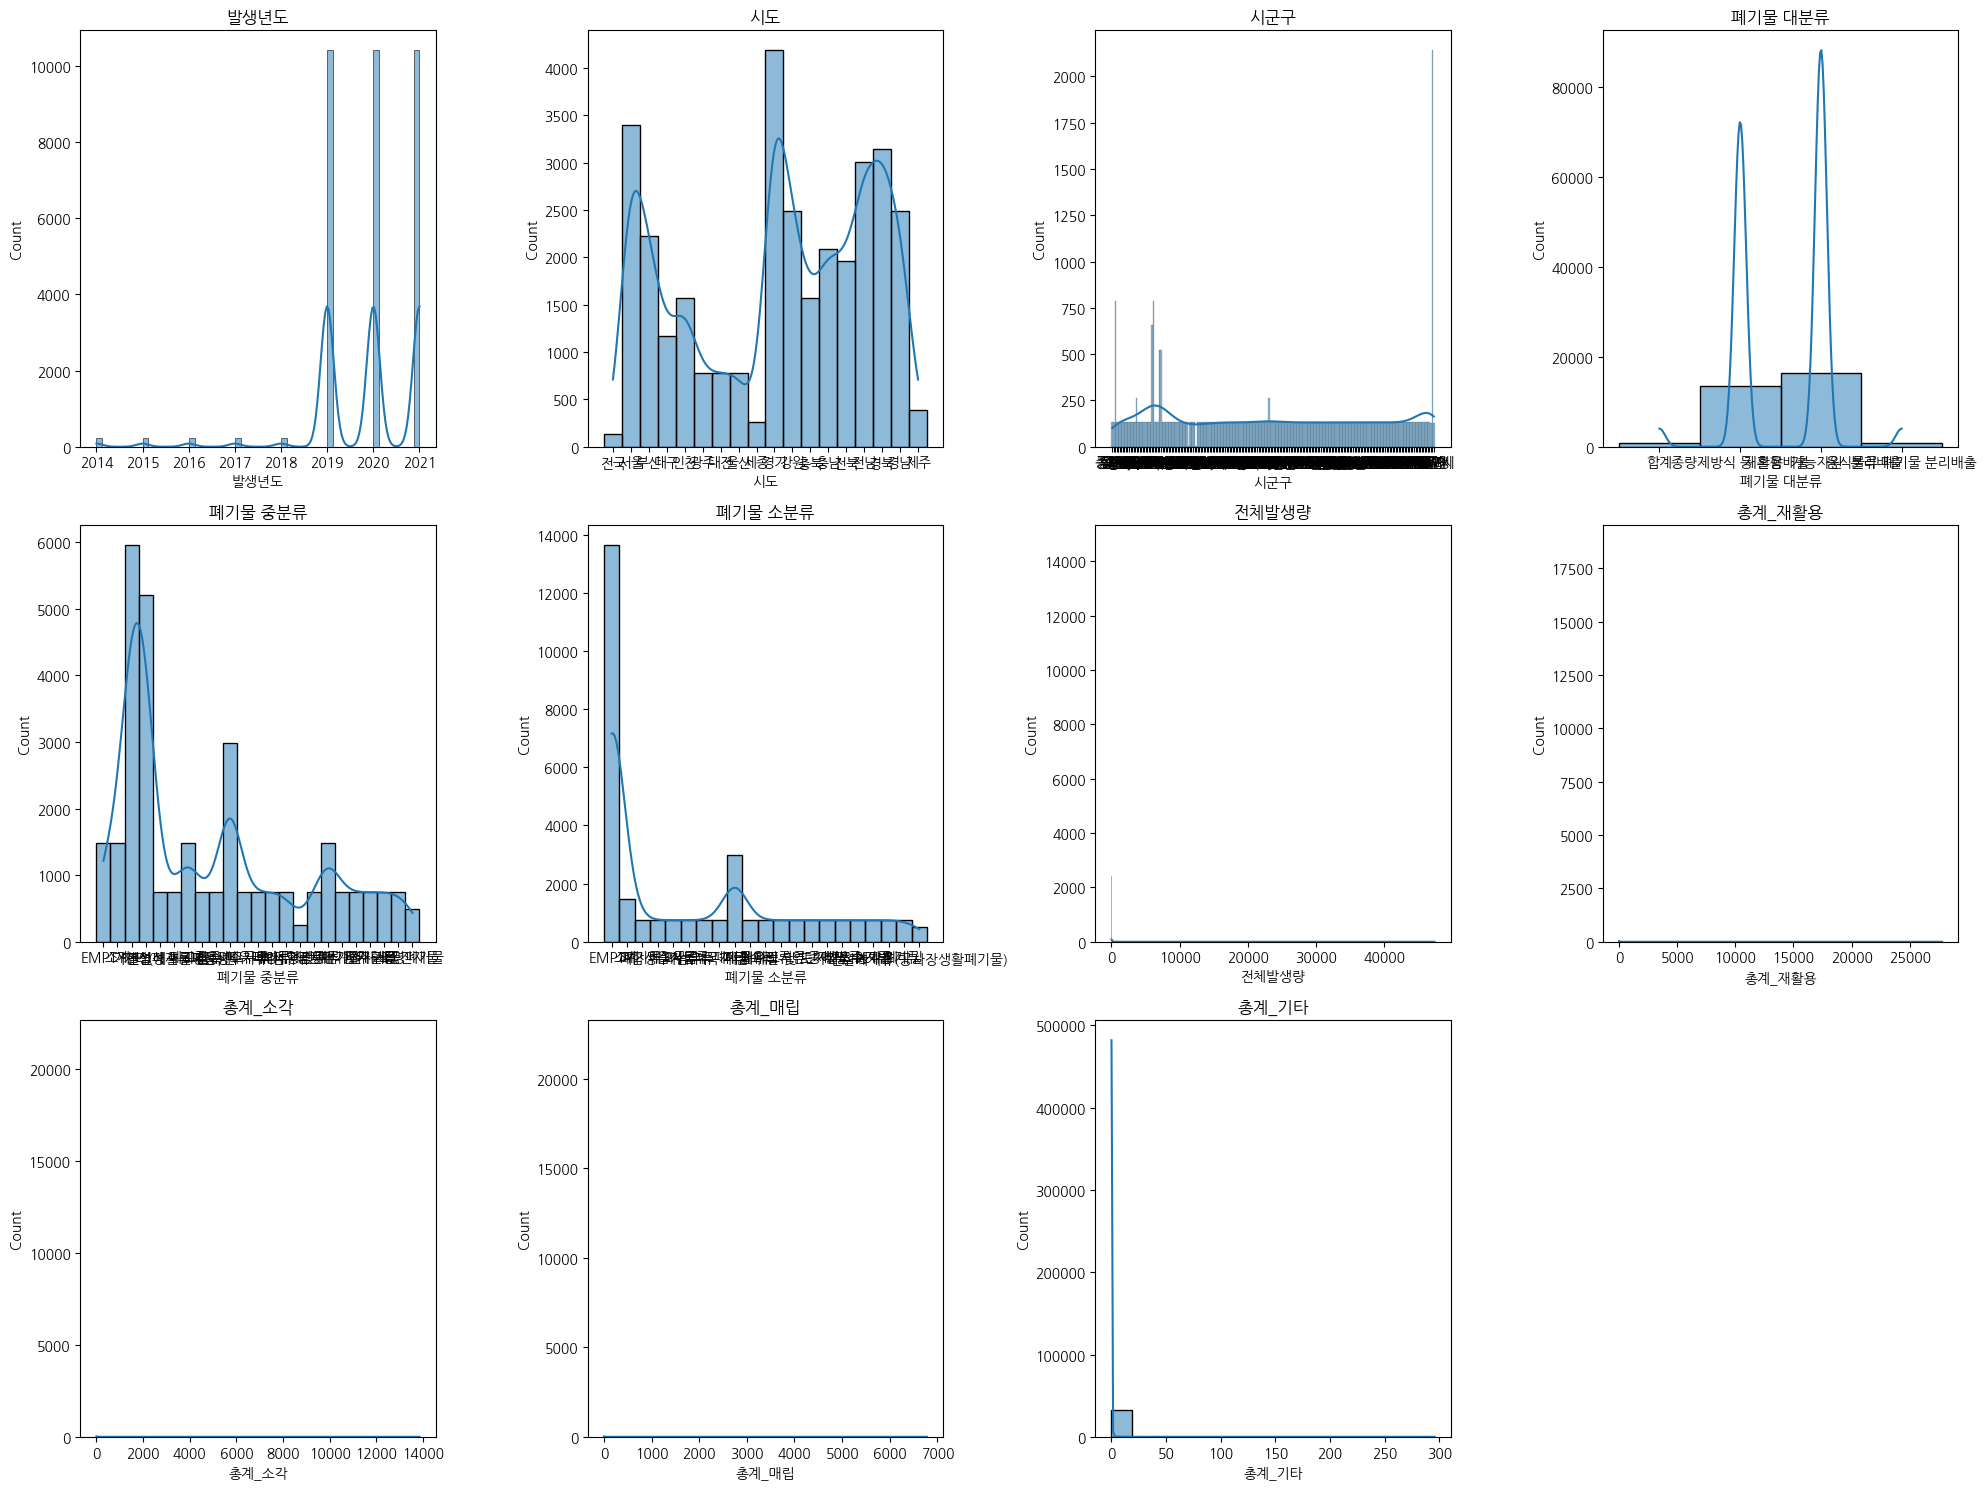

In [7]:
# 데이터의 분포 확인
num_cols = len(data.columns)
num_rows = (num_cols + 3) // 4  # 4개의 컬럼을 한 행에 배치, 필요한 행의 수 계산
fig, axes = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))  # 각 행의 높이를 5로 설정

for i, col in enumerate(data.columns):
    ax = axes[i // 4, i % 4]  # 행 인덱스는 i를 4로 나눈 몫, 열 인덱스는 i를 4로 나눈 나머지
    sns.histplot(data[col], kde=True, ax=ax)
    ax.set_title(col)

# 남은 subplot 공간이 있을 경우 비활성화
for j in range(i + 1, num_rows * 4):
    axes[j // 4, j % 4].axis('off')

plt.tight_layout()
plt.show()

### 데이터를 분석하고 예측 모델을 만들기 위해 다음과 같은 단계로 진행 합니다:

#### 1. 데이터 이해 및 전처리:

- 데이터의 컬럼을 분석하고, 결측값을 처리합니다.
- 명목형, 범주형 변수와 수치형 변수를 식별합니다.
- 데이터의 분포를 시각화하고, 이상치를 탐지합니다.

#### 2. 특성 엔지니어링:

- 필요에 따라 새로운 변수를 생성하거나 기존 변수를 변환합니다.
- 카테고리형 변수를 원-핫 인코딩(one-hot encoding) 또는 라벨 인코딩(label encoding)으로 변환합니다.
- 수치형 변수를 표준화 또는 정규화합니다.

#### 3. 모델 구축 및 평가:

- 데이터를 학습용(train)과 테스트용(test)으로 분할합니다.
- 적절한 회귀(regression) 또는 분류(classification) 모델을 선택합니다.
- 모델을 학습시키고 평가합니다.

먼저, 데이터의 기본 통계를 살펴보고 결측값을 처리한 다음, 시각화를 통해 데이터의 분포를 이해해 보겠습니다.

#### 1. 데이터 이해 및 전처리

In [8]:
# Check for missing values in the dataset
missing_values = data.isnull().sum()

# Display the columns with missing values
missing_values[missing_values > 0]


폐기물 대분류    1155
폐기물 중분류    1155
폐기물 소분류    1155
dtype: int64

"폐기물 대분류", "폐기물 중분류", "폐기물 소분류" 컬럼에 결측값이 존재, 이 결측값들은 모든 행에서 동일하게 발생하고 있어 

우선, 이 결측값들을 처리하는 방법을 고려해야 하는데, 결측값이 있는 행들을 제거하거나 다른 방법으로 채울 수 있고,

결측값이 있는 행들을 제거하고 분석을 진행.

In [9]:
# Drop rows with missing values in '폐기물 대분류', '폐기물 중분류', '폐기물 소분류' columns
data_cleaned = data.dropna(subset=['폐기물 대분류', '폐기물 중분류', '폐기물 소분류'])

# Check the shape of the cleaned data
data_cleaned.shape


(31248, 11)

여기서, 특성이 다른 2019년 이후 데이터 제거하고, 2019년 이전 데이터에서도 특성이 다른 데이터를 제거하고, 남은 데이터를 분석해 보겠습니다.
시도 데이터 중에서 '전국'을 제거하고, 남은 데이터를 분석해 보겠습니다.



In [10]:
# Drop rows with '발생년도' before 2019
data_cleaned = data_cleaned[data_cleaned['발생년도'] < 2019]

# Drop rows with '시도' == '전국'
data_cleaned = data_cleaned[data_cleaned['시도'] != '전국']

# Check the shape of the cleaned data
data_cleaned.shape

(31122, 11)

#### 1. 2. 데이터의 기본 통계 및 시각화

In [11]:
# Display basic statistics for numerical columns
data_cleaned.describe()


,발생년도,전체발생량,총계_재활용,총계_소각,총계_매립,총계_기타
count,31122.00000,31122.000000,31122.000000,31122.000000,31122.000000,31122.000000
mean,2020.00000,28.454836,13.049316,10.248030,5.017839,0.138809
std,0.81651,196.138690,110.849295,85.203169,33.670393,2.590591
min,2019.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2019.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2020.00000,0.900000,0.000000,0.000000,0.000000,0.000000
75%,2021.00000,8.400000,1.500000,0.700000,0.200000,0.000000
max,2021.00000,11069.800000,6283.200000,3851.800000,974.000000,140.900000
